## Load Packages and Data

In [19]:
# These only worked for me in Google Colab (need python version 3.11 or earlier)
%pip install --quiet sentence_transformers
import torch
from sentence_transformers import SentenceTransformer

In [20]:
%pip install --quiet fitz
%pip install --quiet PyMuPDF

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import nltk
from collections import Counter
from wordcloud import WordCloud
import re
from sklearn.metrics.pairwise import cosine_similarity
import fitz
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jerramclaughlin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jerramclaughlin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jerramclaughlin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# data = pd.read_csv('/content/BP_3511.1_cleaned.csv')
data = pd.read_csv('/Users/jerramclaughlin/Policy-Language-Analysis/cleaned_data/BP_3511.1_cleaned.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 41 columns):
 #   Column                                                                           Non-Null Count  Dtype  
---  ------                                                                           --------------  -----  
 0   Unnamed: 0                                                                       512 non-null    int64  
 1   CDS Code                                                                         512 non-null    int64  
 2   County                                                                           512 non-null    object 
 3   District Name                                                                    512 non-null    object 
 4   Locale Classifications                                                           512 non-null    object 
 5   District Type                                                                    512 non-null    object 
 6   2023-24 St

## Word Count Analysis

In [5]:
# create column with the word count for BP
data['BP3511.1: Word Count'] = data['BP3511.1: PDF Text'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

In [6]:
# subset data to word counts and scores
wc_and_scores_df = data[['BP3511.1: Word Count',
                         'District-Wide Curriculum Environmental or Climate Literacy Indicators (up to 3)',
                         'Overall District Action and Literacy Initiative Indicators (up to 10)',
                         'Staff Capacity Indicators (up to 4)',
                         'W/O Policy Environmental and Climate Action Score (17 points)',
                         'Plans, Communication, and Awards Indicators (up to 3)',
                         'District-Wide Campus Sustainability Indicators (up to 3)',
                         'District-Wide Environmental Community and Culture Indicators (up to 3)',
                         'Environmental and Climate Action Score (20 points)']].copy()

In [7]:
# look at summary stats
wc_and_scores_df.describe()

,BP3511.1: Word Count,District-Wide Curriculum Environmental or Climate Literacy Indicators (up to 3),Overall District Action and Literacy Initiative Indicators (up to 10),Staff Capacity Indicators (up to 4),W/O Policy Environmental and Climate Action Score (17 points),"Plans, Communication, and Awards Indicators (up to 3)",District-Wide Campus Sustainability Indicators (up to 3),District-Wide Environmental Community and Culture Indicators (up to 3),Environmental and Climate Action Score (20 points)
count,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000
mean,191.492188,0.699219,3.195801,0.470703,4.082520,0.416016,1.791504,0.555664,7.093262
std,62.328936,0.810498,2.186032,1.038930,3.203342,0.734779,1.052493,0.604393,3.219425
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,167.000000,0.000000,1.500000,0.000000,1.500000,0.000000,0.750000,0.000000,4.500000
50%,191.000000,0.500000,3.000000,0.000000,3.500000,0.000000,2.000000,0.500000,6.500000
75%,195.000000,1.000000,5.000000,0.000000,5.500000,0.500000,3.000000,1.000000,9.000000
max,817.000000,3.000000,9.500000,4.000000,16.500000,3.000000,3.000000,3.000000,19.000000


In [8]:
# rename score columns so they're easier to read
wc_and_scores_df = wc_and_scores_df.rename(
    {
        'District-Wide Curriculum Environmental or Climate Literacy Indicators (up to 3)': 'curriculum_score',
        'Overall District Action and Literacy Initiative Indicators (up to 10)': 'literacy_action_score',
        'Staff Capacity Indicators (up to 4)': 'staff_score',
        'W/O Policy Environmental and Climate Action Score (17 points)': 'no_policy_score',
        'Plans, Communication, and Awards Indicators (up to 3)': 'plans_score',
        'District-Wide Campus Sustainability Indicators (up to 3)': 'sustainability_score',
        'District-Wide Environmental Community and Culture Indicators (up to 3)': 'culture_score',
        'Environmental and Climate Action Score (20 points)': 'climate_action_score',
        'BP3511.1: Word Count': 'bp_wc',

    },
    axis=1
)

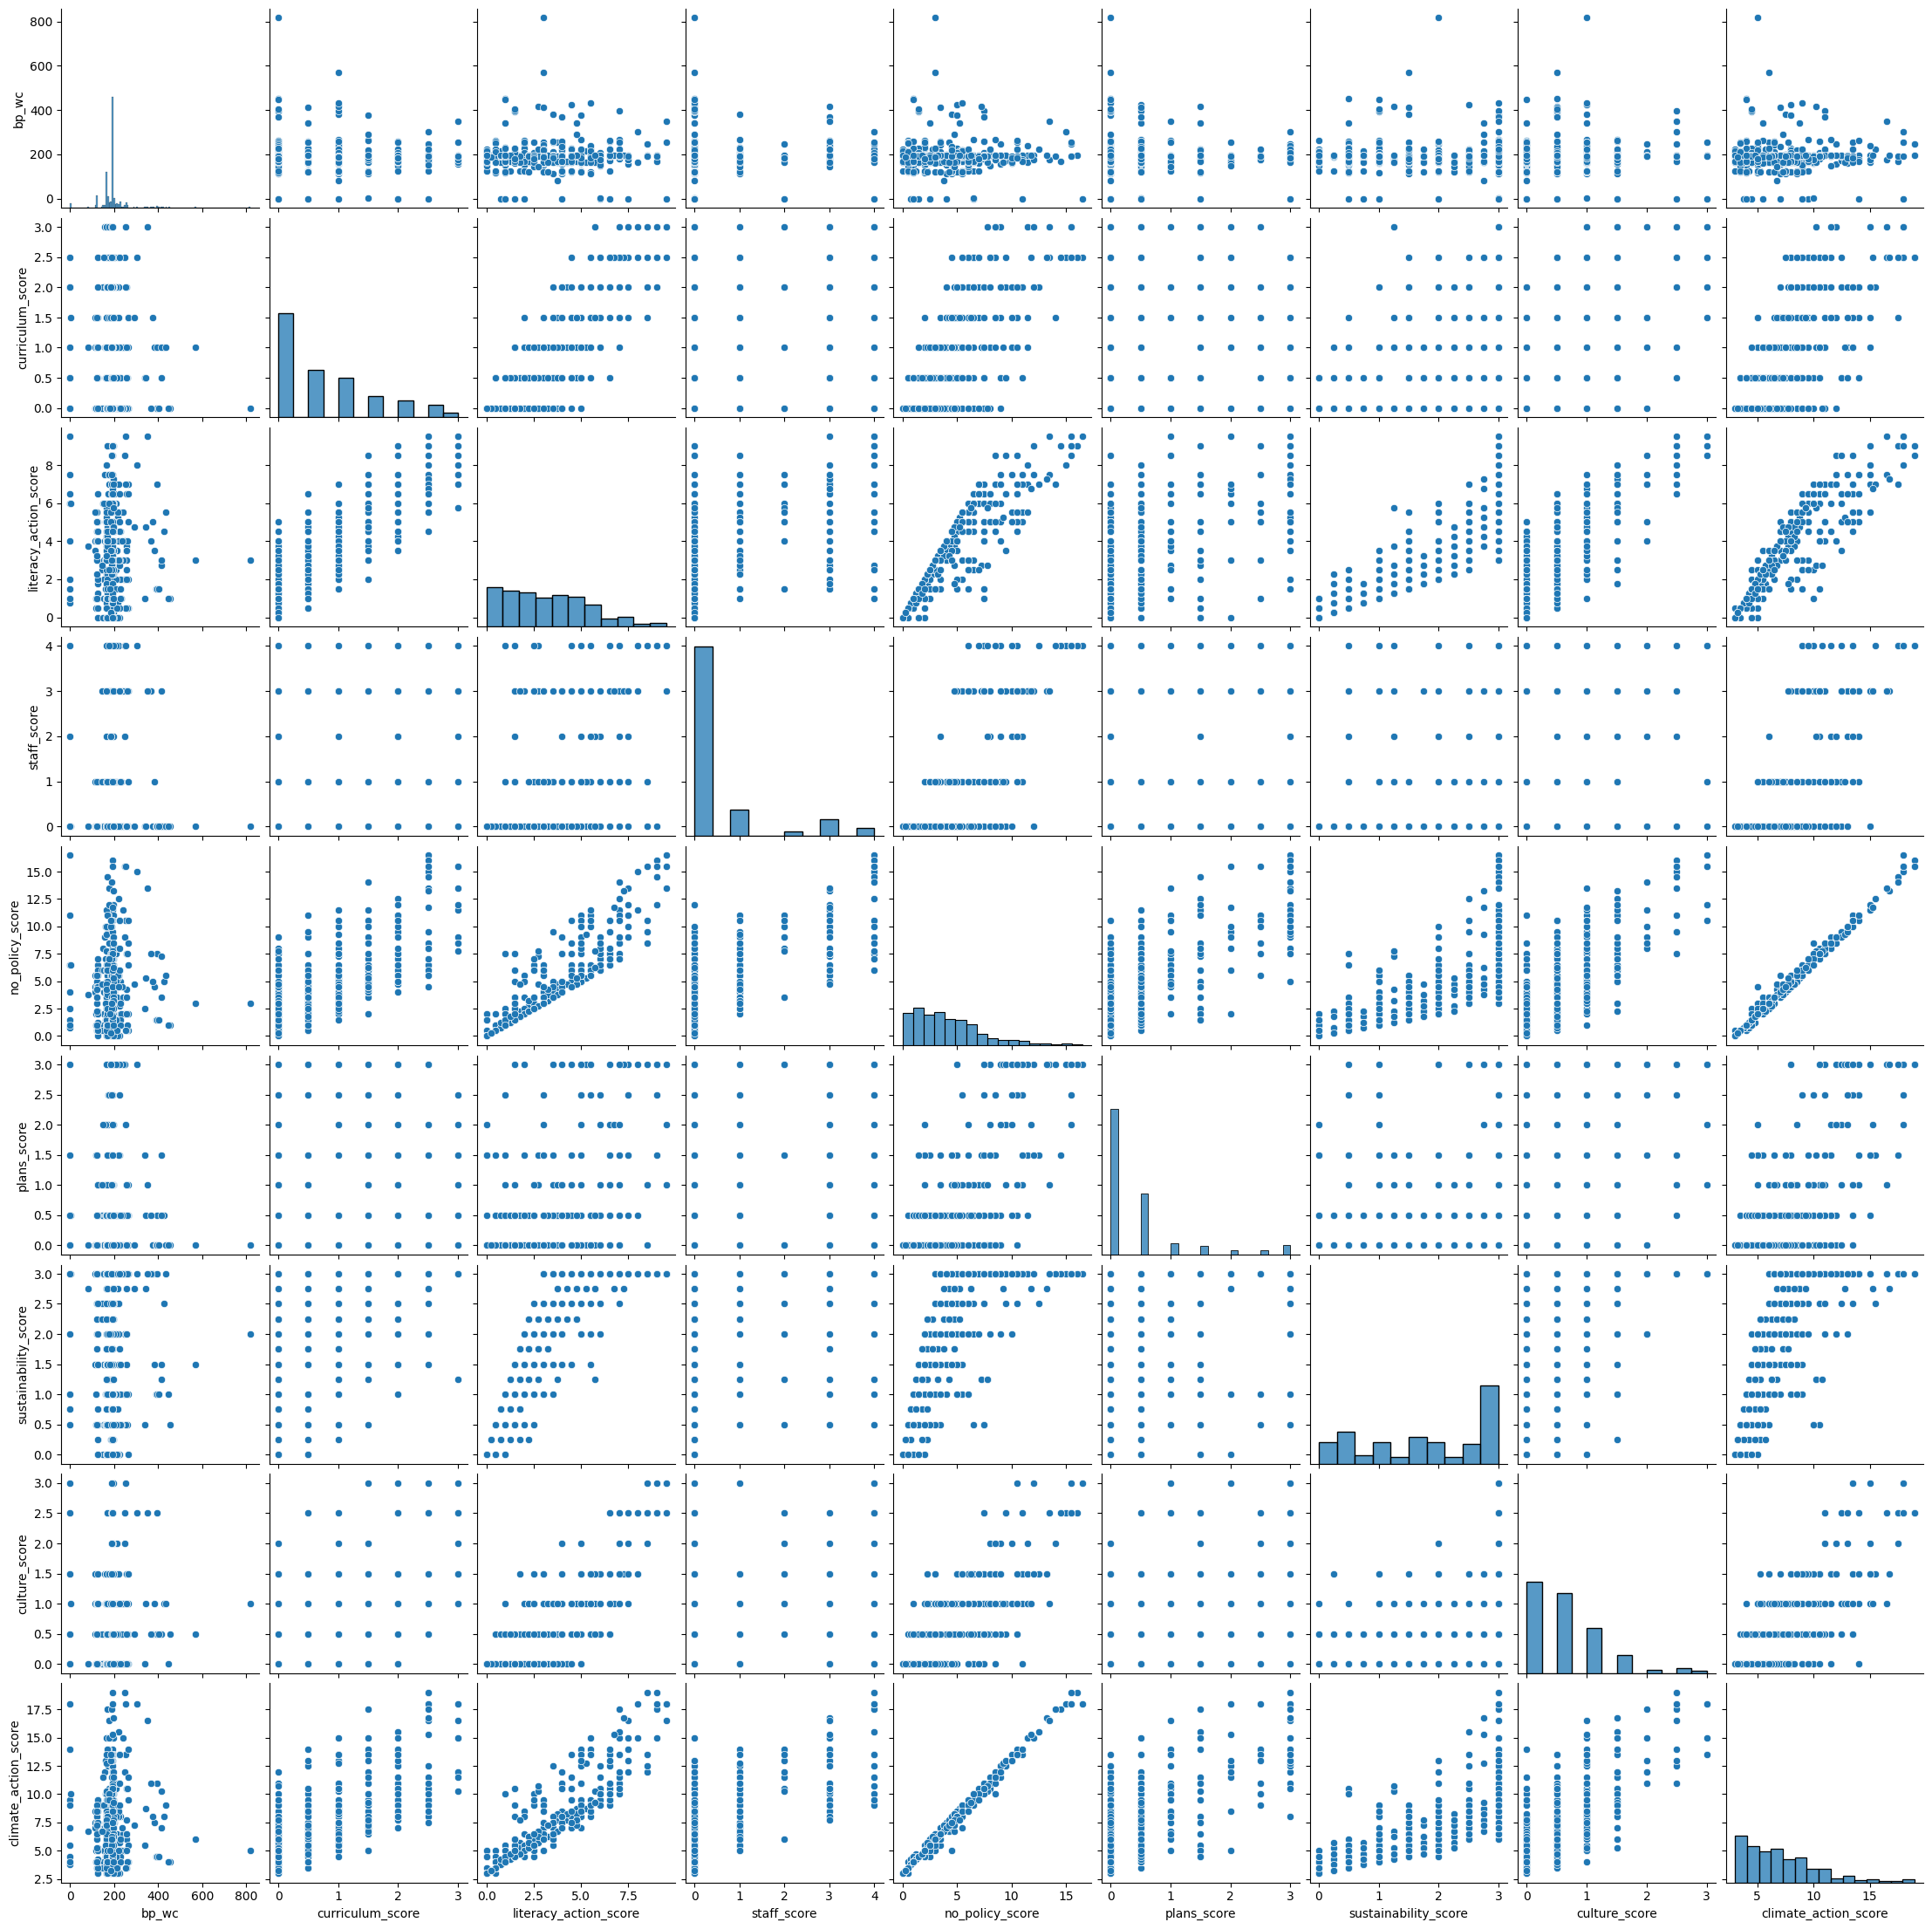

In [9]:
# looking at the distributions of BP word count and the scores
sns.pairplot(data=wc_and_scores_df)

### Overall District Action and Literacy Initiative Indicators ~ BP3511.1 Word Count

                              OLS Regression Results                             
Dep. Variable:     literacy_action_score   R-squared:                       0.000
Model:                               OLS   Adj. R-squared:                 -0.002
Method:                    Least Squares   F-statistic:                   0.02436
Date:                   Fri, 10 Jan 2025   Prob (F-statistic):              0.876
Time:                           12:18:16   Log-Likelihood:                -1126.4
No. Observations:                    512   AIC:                             2257.
Df Residuals:                        510   BIC:                             2265.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1494 

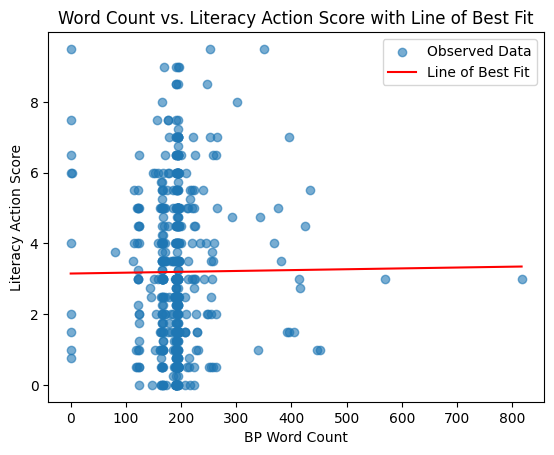

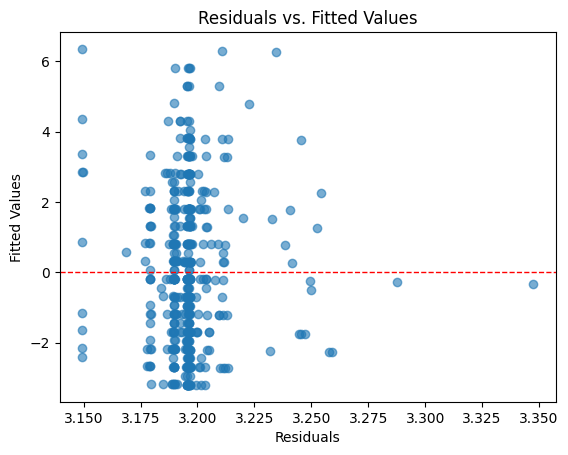

In [10]:
# fit OLS Model
model_ols_wc1 = smf.ols('literacy_action_score ~ bp_wc', data=wc_and_scores_df).fit()

# Print results
print(model_ols_wc1.summary())

# Plot original data
plt.scatter(wc_and_scores_df['bp_wc'], wc_and_scores_df['literacy_action_score'], alpha=0.6, label='Observed Data')
# Generate values for the line of best fit
x = np.linspace(wc_and_scores_df['bp_wc'].min(), wc_and_scores_df['bp_wc'].max(), 100) # range of the predictor
y = model_ols_wc1.params['Intercept'] + model_ols_wc1.params['bp_wc'] * x # Best-fit line equation
# Plot line of best fit
plt.plot(x, y, color='red', label='Line of Best Fit')

# Add labels, title, and legend
plt.xlabel("BP Word Count")
plt.ylabel("Literacy Action Score")
plt.title("Word Count vs. Literacy Action Score with Line of Best Fit")
plt.legend()
plt.show()

# Plot Residuals
plt.scatter(model_ols_wc1.fittedvalues, model_ols_wc1.resid, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1) # add horizontal line at residual = 0
plt.ylabel("Fitted Values")
plt.xlabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

### District-Wide Campus Sustainability Indicators ~ BP3511.1 Word Count

                             OLS Regression Results                             
Dep. Variable:     sustainability_score   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                 -0.002
Method:                   Least Squares   F-statistic:                   0.01014
Date:                  Fri, 10 Jan 2025   Prob (F-statistic):              0.920
Time:                          12:18:18   Log-Likelihood:                -752.19
No. Observations:                   512   AIC:                             1508.
Df Residuals:                       510   BIC:                             1517.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8059      0.151

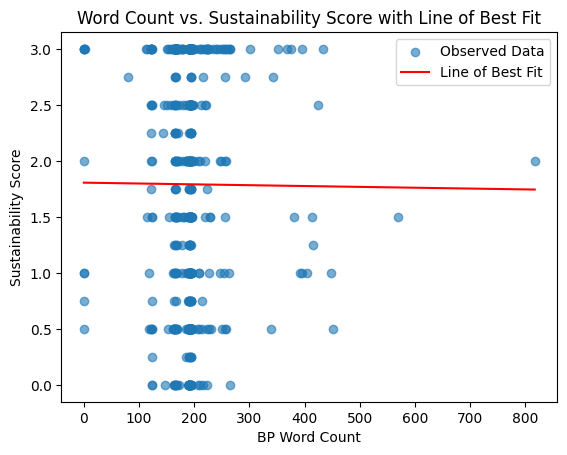

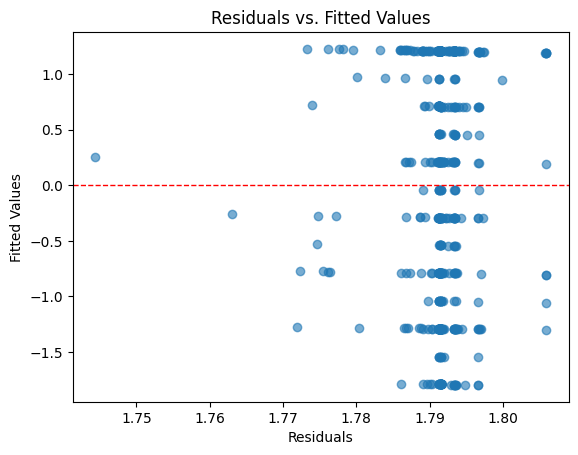

In [11]:
# fit OLS Model
model_ols_wc2 = smf.ols('sustainability_score ~ bp_wc', data=wc_and_scores_df).fit()

# Print results
print(model_ols_wc2.summary())

# Plot original data
plt.scatter(wc_and_scores_df['bp_wc'], wc_and_scores_df['sustainability_score'], alpha=0.6, label='Observed Data')
# Generate values for the line of best fit
x = np.linspace(wc_and_scores_df['bp_wc'].min(), wc_and_scores_df['bp_wc'].max(), 100) # range of the predictor
y = model_ols_wc2.params['Intercept'] + model_ols_wc2.params['bp_wc'] * x # Best-fit line equation
# Plot line of best fit
plt.plot(x, y, color='red', label='Line of Best Fit')

# Add labels, title, and legend
plt.xlabel("BP Word Count")
plt.ylabel("Sustainability Score")
plt.title("Word Count vs. Sustainability Score with Line of Best Fit")
plt.legend()
plt.show()

# Plot Residuals
plt.scatter(model_ols_wc2.fittedvalues, model_ols_wc2.resid, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1) # add horizontal line at residual = 0
plt.ylabel("Fitted Values")
plt.xlabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

### District-Wide Curriculum Environmental or Climate Literacy Indicators ~ BP3511.1 Word Count

                            OLS Regression Results                            
Dep. Variable:       curriculum_score   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4657
Date:                Fri, 10 Jan 2025   Prob (F-statistic):              0.495
Time:                        12:18:20   Log-Likelihood:                -618.19
No. Observations:                 512   AIC:                             1240.
Df Residuals:                     510   BIC:                             1249.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7744      0.116      6.682      0.0

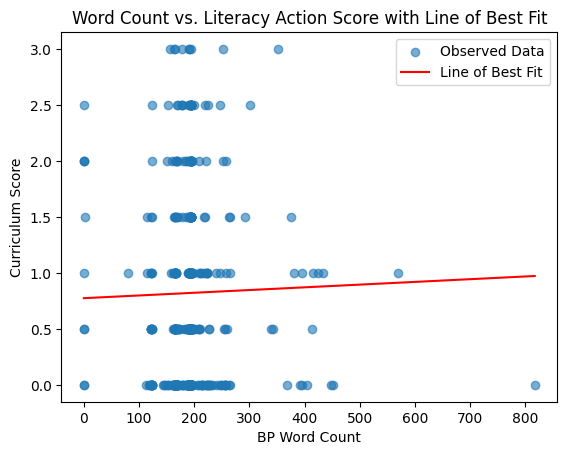

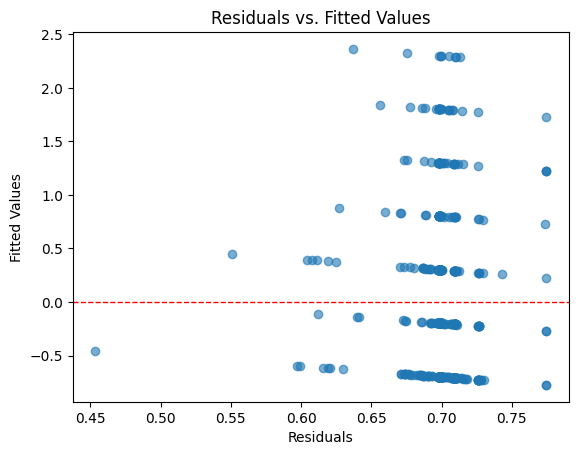

In [12]:
# fit OLS Model
model_ols_wc3 = smf.ols('curriculum_score ~ bp_wc', data=wc_and_scores_df).fit()

# Print results
print(model_ols_wc3.summary())

# Plot original data
plt.scatter(wc_and_scores_df['bp_wc'], wc_and_scores_df['curriculum_score'], alpha=0.6, label='Observed Data')
# Generate values for the line of best fit
x = np.linspace(wc_and_scores_df['bp_wc'].min(), wc_and_scores_df['bp_wc'].max(), 100) # range of the predictor
y = model_ols_wc3.params['Intercept'] + model_ols_wc1.params['bp_wc'] * x # Best-fit line equation
# Plot line of best fit
plt.plot(x, y, color='red', label='Line of Best Fit')

# Add labels, title, and legend
plt.xlabel("BP Word Count")
plt.ylabel("Curriculum Score")
plt.title("Word Count vs. Literacy Action Score with Line of Best Fit")
plt.legend()
plt.show()

# Plot Residuals
plt.scatter(model_ols_wc3.fittedvalues, model_ols_wc3.resid, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1) # add horizontal line at residual = 0
plt.ylabel("Fitted Values")
plt.xlabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.show()

## BP3511.1 Regression Findings ##
Based on these regression models, I conclude that there is no statistically signifcant relationship between the Board Policy 3511.1 word count and the the following scores:

- Overall District Action and Literacy Initiative Indicators (literacy_score)
- District-Wide Campus Sustainability Indicators (sustainability_score)
- District-Wide Curriculum Environmental or Climate Literacy Indicators (curriculum_score).
  
Since the distributions for climate_action_score and no_policy_score are similar to literacy_score, it is likely these scores also have no relationship with the Board Policy 3511.1 word count.

Similarly, since the distributions for staff_score, plan_score, and culture_score are similar to curriculum_score it is likely these scores also have no relationship with the Board Policy 3511.1 word count.

# Word Frequency Analysis

In [13]:
# Define function that will return the most frequent words
def top_ten_words(text):
    """ returns the most common words/tokens in a string.
    handles non-string or null values by returning and empty list.
    """
    if not isinstance(text, str):
        return []
    list_of_words = nltk.word_tokenize(text) # gives list of tokens
    token_counts = nltk.FreqDist(list_of_words) # FreqDist gives a count for how often each word occurs in the text
    most_common = token_counts.most_common(10) # shows the top 10 words in the text
    return most_common

# Define function for additional cleaning
def more_cleaning(text):
    if not isinstance(text, str):
        return []
    text = re.sub(r'cf', '', text, flags=re.IGNORECASE)
    text = re.sub(r'ccr', '', text, flags=re.IGNORECASE)
    text = re.sub(r'http', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [14]:
# apply functions
data['BP3511.1: PDF Text'] = data['BP3511.1: PDF Text'].apply(more_cleaning)

# create column with most common words
data['top_words'] = data['BP3511.1: PDF Text'].apply(top_ten_words)

In [15]:
data.head()

,Unnamed: 0,CDS Code,County,District Name,Locale Classifications,District Type,2023-24 Student Enrollment,2023-24 % Unduplicated,BP: 3511.1 Integrated Waste Management,BP 3511.1 Year Adopted,...,"Plans, Communication, and Awards Indicators (up to 3)",District-Wide Campus Sustainability Indicators (up to 3),District-Wide Environmental Community and Culture Indicators (up to 3),Environmental and Climate Action Score (20 points),BP3511.1: Path to PDF,BP3511.1: PDF Text,AR3511.1: Path to PDF,AR3511.1: PDF Text,BP3511.1: Word Count,top_words
0,0,1611190000000,Alameda,Alameda Unified,Suburban,Unified School District,10557,41,1,2012,...,2.5,3.0,1.5,14.0,Alameda_Unified_BP3511_1.pdf,policy integrated waste management status ado...,NaN,NaN,194,"[(waste, 10), (management, 9), (district, 8), ..."
1,1,1611270000000,Alameda,Albany City Unified,Suburban,Unified School District,3574,37,1,2013,...,1.5,3.0,2.0,15.0,Albany_City_Unified_BP3511_1.pdf,policy integrated waste management status ado...,NaN,NaN,194,"[(waste, 10), (management, 9), (district, 8), ..."
2,2,1611500000000,Alameda,Castro Valley Unified,Suburban,Unified School District,9489,43,1,2011,...,1.0,3.0,1.5,10.5,Castro_Valley_Unified_BP3511_1.pdf,book board policy section business noninstruc...,NaN,NaN,257,"[(management, 12), (waste, 11), (integrated, 9..."
3,3,1611680000000,Alameda,Emery Unified,Suburban,Unified School District,600,81,1,2004,...,0.0,2.5,0.5,6.0,Emery_Unified_BP3511_1.pdf,policy integrated waste management status ado...,NaN,NaN,122,"[(waste, 6), (integrated, 4), (management, 4),..."
4,4,1611760000000,Alameda,Fremont Unified,Suburban,Unified School District,33063,33,0,NaN,...,1.5,3.0,2.5,14.0,NaN,[],NaN,NaN,0,[]


In [16]:
# find highest and lowest sustainability scores
max_score = data['District-Wide Campus Sustainability Indicators (up to 3)'].max()
min_score = data['District-Wide Campus Sustainability Indicators (up to 3)'].min()
print('max:', max_score)
print('min:', min_score)

max: 3.0
min: 0.0


In [17]:
# group by highest and lowest sustainability scores
high_score = data[(data['District-Wide Campus Sustainability Indicators (up to 3)'] == 3.0)].copy()
low_score = data[(data['District-Wide Campus Sustainability Indicators (up to 3)'] == 0.0)].copy()

In [18]:
# combine top words for high-scoring and low-scoring school districts
hs_words_list = high_score['top_words'].sum()
ls_words_list = low_score['top_words'].sum()

# count the occurences of each word across the top rows
hs_word_counts = Counter(dict(hs_words_list))
ls_word_counts = Counter(dict(ls_words_list))

# find most common words
highest_word_df = pd.DataFrame(hs_word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).set_index('Word')
lowest_word_df = pd.DataFrame(ls_word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False).set_index('Word')

In [19]:
hs_top10 = highest_word_df.head(10)
ls_top10 = lowest_word_df.head(10)
print('High Score Districts:', hs_top10)
print('Low Score Districts:', ls_top10)

High Score Districts:             Frequency
Word                 
waste              29
material           14
organic            13
management         11
recycling          11
district            8
integrated          8
shall               7
program             6
pub                 6
Low Score Districts:                          Frequency
Word                              
waste                           10
management                       9
district                         8
integrated                       7
program                          7
shall                            6
superintendent                   5
designee                         5
superintendentprincipal          5
natural                          4


<function matplotlib.pyplot.show(close=None, block=None)>

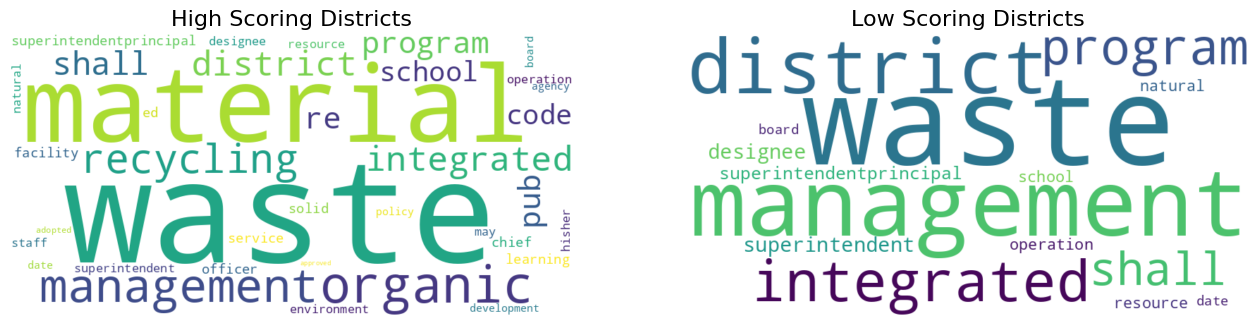

In [20]:
# Create word cloud
hs_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(hs_word_counts)
ls_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(ls_word_counts)

plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.imshow(hs_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('High Scoring Districts', fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(ls_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Low Scoring Districts', fontsize=16)

plt.show

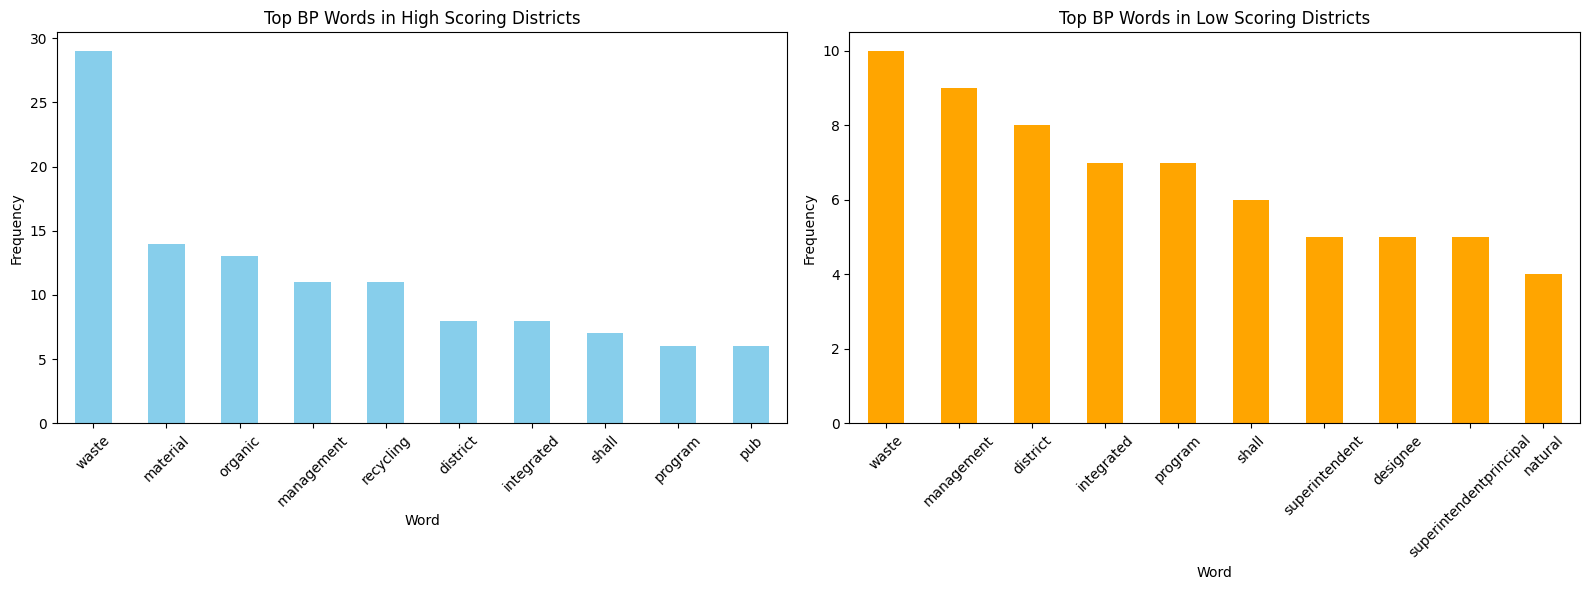

In [21]:
# create bar graph
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# high scoring districts
hs_top10.plot(kind='bar', ax=axes[0], color='skyblue', legend=False)
axes[0].set_title('Top BP Words in High Scoring Districts')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)

# low scoring districts
ls_top10.plot(kind='bar', ax=axes[1], color='orange', legend=False)
axes[1].set_title('Top BP Words in Low Scoring Districts')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=45)

# adjust layout
plt.tight_layout()
plt.show()

## Template Comparison

In [41]:
# worked out of colab because my local version of python was incompatable with PyTorch

In [42]:
# load data from google drive
df = pd.read_csv('/content/BP_3511.1_cleaned.csv')

In [43]:
# load template from drive
template_path = "/content/3511_1_Template.pdf"

In [44]:
# define functions to extract and clean template text
def extract_text_from_pdf(pdf_path):
  '''Function to extract text from PDF'''
  try:
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
      text += page.get_text()
    return text
  except Exception as e:
    print(f"Error extracting text from PDF: {e}")
    return None

def clean_pdf_text(text):
  """
  Cleans up textual data by lowercasing all letters, removing punctuation, removing stop words,
  and lemmatizing.
  """
  text = re.sub(r'Education code.*$', '', text, flags=re.IGNORECASE)
  text = re.sub(r'legal reference.*', '', text, flags=re.IGNORECASE | re.DOTALL) # Use regex to remove 'legal reference' and everything after
  text = text.lower() # Lowercase text
  tokens = word_tokenize(text) # Tokenize text
  tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens if re.sub(r'[^\w\s]', '', token)] # Regular expression to match punctuation
  stop_words = set(stopwords.words('english')) # Define stop words
  tokens = [word for word in tokens if word not in stop_words] # Remove stop words
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmetize
  cleaned_text = ' '.join(tokens) # Join tokens back into a string

  return cleaned_text


In [45]:
template = extract_text_from_pdf(template_path)
template = clean_pdf_text(template)
template

'csba sample bp 35111 board policy business non instructional operation bp 35111 integrated waste management note following optional policy may revised reflect district practice pursuant public resource code 42630 school encouraged assist city county meeting solid waste diversion goal set public resource code 41780 addition pursuant public resource code 426492 added ab 341 ch 476 statute 2011 business including school generate four cubic yard solid waste per week required arrange recycling service accordance law useful resource specific waste management strategy available funding source publication including resource developing implementing integrated education program link instruction integrated waste management environmental concept student action project school site may obtained california department resource recycling recovery calrecycle governing board belief conservation natural resource protection environment connected district educational mission essential health wellbeing comm

In [46]:
# create mebedding from the text
# create model instance
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# define embedding function to deal w/ null values
def get_embedding(text):
  """
  Get embedding for a string. If the output is not a string, return a zero vector.
  """
  if not isinstance(text, str):
    return np.zeros(384)
  return embedding_model.encode(text)

# get template embedding
temp_embedding = get_embedding(template)

# subset data
PDF = df['BP3511.1: PDF Text'].copy()

# empty list to store similarity scores
similarity_scores = []

# iterate through each pdf text to get similarity to template
for pdf in PDF:
  embedding = get_embedding(pdf)
  similarity = cosine_similarity([temp_embedding], [embedding])
  similarity_scores.append(similarity[0][0])

# convert to DataFrame
similarity_df = pd.DataFrame({
    'District Name': df['District Name'],
    'Similarity': similarity_scores,
    'Sustainability_Score': df['District-Wide Campus Sustainability Indicators (up to 3)']
})

# sort districts by similarity score
most_similar = similarity_df.sort_values(by='Similarity', ascending=False).head(20)
most_similar

,District Name,Similarity,Sustainability_Score
38,Pittsburg Unified,0.916017,3.00
494,Mesa Union Elementary,0.911129,1.50
342,Pleasant Valley Joint Union Elementary,0.900461,0.75
21,Calaveras Unified,0.900389,3.00
362,South San Francisco Unified,0.888462,3.00
418,Fairfield-Suisun Unified,0.887899,1.00
321,San Dieguito Union High,0.886079,3.00
359,San Bruno Park Elementary,0.885583,1.00
315,Julian Union High,0.885235,0.50
142,Castaic Union,0.884993,1.00


                             OLS Regression Results                             
Dep. Variable:     Sustainability_Score   R-squared:                       0.001
Model:                              OLS   Adj. R-squared:                 -0.001
Method:                   Least Squares   F-statistic:                    0.5285
Date:                  Fri, 10 Jan 2025   Prob (F-statistic):              0.468
Time:                          20:12:54   Log-Likelihood:                -751.93
No. Observations:                   512   AIC:                             1508.
Df Residuals:                       510   BIC:                             1516.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0313      0.333

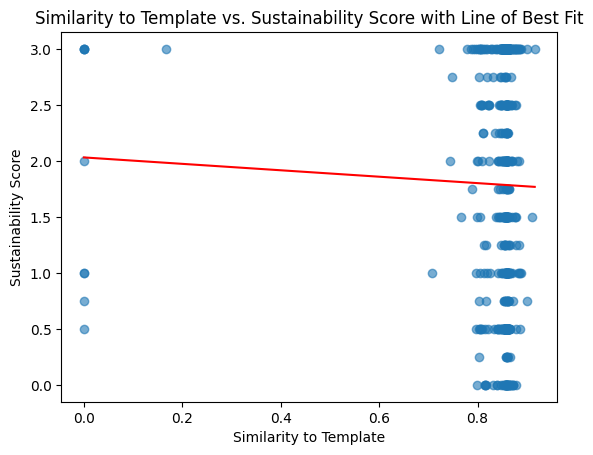

In [47]:
# fit model
model_ols = smf.ols('Sustainability_Score ~ Similarity', data=similarity_df).fit()

# Print results
print(model_ols.summary())

# Plot original data
plt.scatter(similarity_df['Similarity'], similarity_df['Sustainability_Score'], alpha=0.6)

# Plot line of best fit
x = np.linspace(similarity_df['Similarity'].min(), similarity_df['Similarity'].max(), 100) # range of the predictor
y = model_ols.params['Intercept'] + model_ols.params['Similarity'] * x # Best-fit line equation
plt.plot(x, y, color='red', label='Line of Best Fit')

# Add labels, title, and legend
plt.xlabel("Similarity to Template")
plt.ylabel("Sustainability Score")
plt.title("Similarity to Template vs. Sustainability Score with Line of Best Fit")
plt.show()